<a href="https://colab.research.google.com/github/mohammad444t/Gamein2020-Prototype/blob/master/prototype_with_rfq_(v2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install python-telegram-bot

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pandas==1.1.0

In [17]:
import numpy as np 
import pandas as pd 
import random
import math
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.animation
import time
pd.__version__


'1.1.0'

Shah1990
چوب
500
5
   buyer_name product_name amount delivery_turn max_price deadline request_turn
48   Shah1990          چوب    500             5    500000        2            1


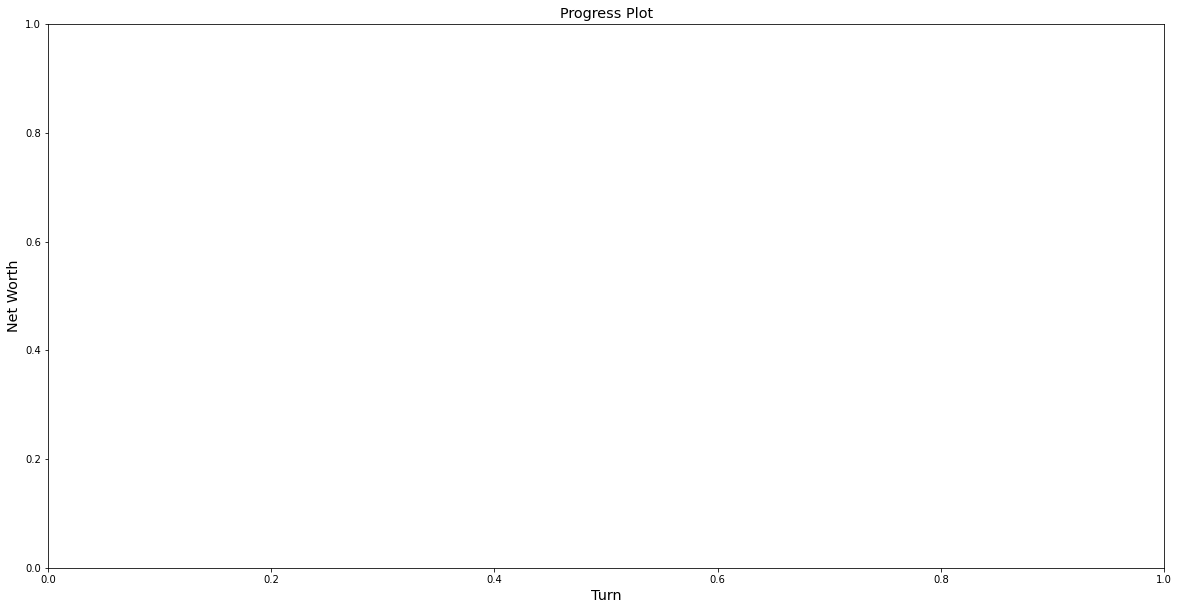

In [24]:
# %matplotlib notebook
class Parameters():
  ###################### reading all dataframes from google drive ...... to call them faster and easier in runtime 

  land_stockhouse_df = pd.read_excel("/content/drive/My Drive/projects/gamein_prototype/parameters.xlsx",sheet_name="land_stockhouse", header=0,index_col=0)
  land_machine_df = pd.read_excel("/content/drive/My Drive/projects/gamein_prototype/parameters.xlsx",sheet_name="land_machine", header=0,index_col=0)
  machines_info_df = pd.read_excel("/content/drive/My Drive/projects/gamein_prototype/parameters.xlsx",sheet_name="machines_info", header=0,index_col=0)
  products_volume_df = pd.read_excel("/content/drive/My Drive/projects/gamein_prototype/parameters.xlsx",sheet_name="products_info", header=0,index_col=0)
  bom_price_df = pd.read_excel("/content/drive/My Drive/projects/gamein_prototype/parameters.xlsx",sheet_name="bom_price", header=0,index_col=0)
  bom_df = pd.read_excel("/content/drive/My Drive/projects/gamein_prototype/parameters.xlsx",sheet_name="bom", header=0,index_col=0)
  gamein_buy_price_df = pd.read_excel("/content/drive/My Drive/projects/gamein_prototype/parameters.xlsx",sheet_name="gamein_buy_price", header=0,index_col=0) #milad : added .... price of products that gamein buys
  gamein_sell_price = pd.read_excel("/content/drive/My Drive/projects/gamein_prototype/parameters.xlsx",sheet_name="gamein_sell_price", header=0,index_col=0)
  land_information_df = pd.read_excel("/content/drive/My Drive/projects/gamein_prototype/parameters.xlsx",sheet_name="land_information", header=0,index_col=0)
  gamein_liquidity_price_df = pd.read_excel("/content/drive/My Drive/projects/gamein_prototype/parameters.xlsx",sheet_name="gamein_liquidity_price", header=0,index_col=0)
class Player():
  players_name=[]

  def __init__(self, player_name):
    self.name = player_name
    # remove from available
    self.cash = 16000000 # بودجه اولیه
    #sara 
    #میتونیم پولش رو همون اول که داره درخواست میذاره با همون ماکزیمم قیمت محاسبه کنیم و بلوکه کنیم یا موقع عقد قرارداد. اولی خوبی اش اینه که اونی که به عنوان تامین کننده میاد هم اطمینان بیشتری داره 
    #ولی خب شاید دومی به جهان واقع نزدیکتر باشه ضمن اینکه کار ما رو هم راحت تر میکنه، چون در حالت اول، اگر با قیمت کمتر پذیرفته بشه یه دور انتقال پول دیگه هم داریم... .
    self.blocked_cash = 0
    self.land_objects=dict()
    #به این داشبوردها دو جور میتونیم نگاه کنیم:
    #از دید من به عنوان یا از دید سایرین نسبت به من
    
   # من فکر میکنم همه شون ستون های یکسانی دارن، ولی خب برای ما متفاوت اند.
    self.request_dashboard = pd.DataFrame([], columns = ["buyer_name", "product_name", "amount", "price", "expected_turn"]) #تامین کننده هایی که پذیرفتند
    self.won_offers_dashboard = pd.DataFrame([], columns = ["buyer_name", "product_name", "amount", "price", "expected_turn"]) 
    self.lost_offers_dashboard = pd.DataFrame([], columns = ["buyer_name", "product_name", "amount", "price", "expected_turn"]) 

  def calculate_final_net_worth(self):
    #to calculate final net worth
    # inventory_value_sum=sum([self.land_objects[land].calculate_inventory_value() for land in list(self.land_objects.keys())]) #nima jaygozine 3 khate bala
    # net_worth = inventory_value_sum + self.cash 
    #اینجا تغییر دادم:
    #outhand_coefficient = 0.5
    inhand_coefficient = 1
    #machine_coefficient  = 0.8  
    player_cash = self.cash 
    
    player_land = list(self.land_objects.values())[0]
    player_stockhouse = player_land.stockhouse
    player_machine_df = player_land.machine
    player_inventory_df = player_stockhouse.inventory_df
    player_stockhouse_worth = 0
    player_machine_worth = 0
    player_wip_worth = 0

    for item, row in player_inventory_df.iterrows():
      if not pd.isnull(row.inhand_inventory) :#agar avali null nabashe dovomi ham ghataan null nist و باید دونه دونه محصولات رو بررسی کنیم اگر مدل آقای اخوان بخواد باشه. چون هزینه ثابت ها متفاوته.
        amount_inhand = player_inventory_df.loc[item, 'inhand_inventory']
        price = Parameters.gamein_liquidity_price_df.loc[item, "buy_price"]
        player_stockhouse_worth += (price * amount_inhand * inhand_coefficient) 
     

    for item, row in player_machine_df.iterrows():
      machine = row.loc["machine_obj"]
      machine_id = machine.id
      machine_price = Parameters.machines_info_df.loc[machine_id, "machine_price"]
      #sara
      #اگر ایندکس رو اون طور که در add_machine هست محاسبه کنیم:
      machine_index = item
      depreciation_rate = 0.0125 * (Controller.turn - (machine_index // 1000))
      salvage_rate = 1 - depreciation_rate
      player_machine_worth += (machine_price * salvage_rate)
      

      machine_remaining_production = machine.remaining_production
      machine_total_production = machine.total_production
      machine_fixed_production = machine.fixed_production_cost
      machine_variable_production = machine.production_cost_per_unit

      if machine_remaining_production == 0:
        fixed_cost_per_unit = 0
      else: 
        fixed_cost_per_unit = machine_fixed_production / machine_total_production

      product_name = machine.product_name
      bom_price = Parameters.bom_price_df.loc[product_name, "bom_price"]

      player_wip_worth += ((fixed_cost_per_unit * machine_remaining_production) +
                           (machine_variable_production * machine_remaining_production) + (bom_price * machine_remaining_production))


    

    
    net_worth = player_machine_worth + player_stockhouse_worth + player_cash + player_wip_worth
    print("@@@@@@@@@@@@@@@@@")
    print(self.name)
    print('Machine:')
    print(machine.machine_name)
    print('Stockhouse worth:')
    print(player_stockhouse_worth)
    print('Machine worth:')
    print(player_machine_worth)
    print('WIP worth:')
    print(player_wip_worth)
    print("#################")
    # print(player_machine_worth)
    # print(player_stockhouse_worth)
    # print(player_cash)

    return net_worth 

  def add_land(self, land_id):
    self.land_objects.update({land_id : Land(land_id)}) # یه اینستنس از لند میسازه که ورودی بهش آیدی میدیم . بعد توی خود لند ، بر حسب آیدی بقیه فیچر های لند رو ست میکنیم
    

  # def add_machine(self, land_id, machine_id):
  #   self.land_objects[land_id].add_machine(machine_id)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
  def add_offer_to_request_dashboard(self, offer_id, request_id):
    request = Demand_market.requests.loc[request_id]
    offer = Demand_market.responded_requests.loc[offer_id]
    offerer_name = self.name
    buyer_name = request.buyer_name
    product_name = request.product_name
    amount = request.amount
    expected_turn = offer.expected_turn
    price = offer.price
    # product_on_request_dashboard_id = random.choice([i for i in range(1000) if not(i in request_dashboard.index)]) 
    new_row = [buyer_name, product_name, amount, price, expected_turn]
    self.request_dashboard.loc[offer_id] = new_row

  def add_offer_to_won_offers_dashboard(self, offer_id, request_id):
    request = Demand_market.requests.loc[request_id]
    offer = Demand_market.responded_requests.loc[offer_id]
    offerer_name = self.name
    buyer_name = request.buyer_name
    product_name = request.product_name
    amount = request.amount
    expected_turn = offer.expected_turn
    price = offer.price
    product_on_won_offers_dashboard_id = random.choice([i for i in range(1000) if not(i in self.won_offers_dashboard.index)]) 
    new_row = [buyer_name, product_name, amount, price, expected_turn]
    self.won_offers_dashboard.loc[product_on_won_offers_dashboard_id] = new_row

  def add_offer_to_lost_offers_dashboard(self, offer_id, request_id):
    request = Demand_market.requests.loc[request_id]
    offer = Demand_market.responded_requests.loc[offer_id]
    offerer_name = self.name
    buyer_name = request.buyer_name
    product_name = request.product_name
    amount = request.amount
    expected_turn = offer.expected_turn
    price = offer.price
    product_on_lost_offers_dashboard_id = random.choice([i for i in range(1000) if not(i in self.lost_offers_dashboard.index)]) 
    new_row = [buyer_name, product_name, amount, price, expected_turn]
    self.lost_offers_dashboard.loc[product_on_lost_offers_dashboard_id] = new_row

  def remove_offer_from_request_dashboard(self, product_on_request_dashboard_id):
    print(self.request_dashboard)
    self.request_dashboard.drop(product_on_request_dashboard_id, inplace=True)

  def update_expected_turn(self):
    for turn, row in self.request_dashboard.iterrows():
      if row.expected_turn != 0:
        row.expected_turn -= 1
    for turn, row in self.won_offers_dashboard.iterrows():
      if row.expected_turn != 0:
        row.expected_turn -= 1
    for turn, row in self.lost_offers_dashboard.iterrows():
      if row.expected_turn != 0:
        row.expected_turn -= 1


  

class Gamein_Bazaar():
  def put_into_market():
    pass

class Land():
  lands_list = list(Parameters.land_machine_df.index) #amirreza یه دیتا فریم که یه آی دی زمین داره و ماشین
  available_lands= lands_list.copy() #آی دی های باقی مانده
  


  def __init__(self, land_id):
    self.machine = pd.DataFrame([], columns=['machine_obj'])
    self.id = land_id
    self.cap = Parameters.land_stockhouse_df.loc[int (self.id), "cap"]
    self.stockhouse = StockHouse(self.cap) 
    # اینجا دیگه دیکشنری نیست چون فرض بر اینه که یه دونه انبار بیشتر نداریم 
    #elf.location = Location.land_information.loc[self.id, "locations_name"]
    #self.machine_cap = Parameters.land_information.loc[self.id, "machine_cap"]

    # self.stockhouse = StockHouse()
  def add_machine(self, machine_id):
    #sara
    #برای اینکه ترن هر ماشین رو داشته باشیم که موقع محاسبه استهلاک به دردمون بخوره یه کار اینه که یک ستون به اون دیتافریم اضافه کنیم مثلا
    #یه چیز دیگه هم که داشتم بهش فکر میکردم این بود که در محاسبه‌ی ایندکس مون دخیل کنیم ترن رو
    #مثلا از طریق زیر بدست بیاد، و اینطوری هزارگان هر ایندکسی زمان خرید ماشین رو بهمون میده
    #و در محاسبه استهلاک میتونیم ازش استفاده کنیم:
    #مثلا بگیم خارج قسمت تقسیم این ایندکس بر 1000
    machine_index = (1000*Controller.turn) + random.choice([i for i in range(100) if not(i in self.machine.index - ((1000*Controller.turn)))]) 
    #machine_index = random.choice([i for i in range(100) if not(i in self.machine.index)]) 
    self.machine.loc[machine_index] = Machine(machine_id)


class Demand_market():
  requests = pd.DataFrame([], columns=["buyer_name","product_name", "amount", "delivery_turn","max_price", "deadline", "request_turn"])
  responded_requests = pd.DataFrame([], columns=["offerer_name","request_id","price", "expected_turn"])
  def reset_vitrin():
    Demand_market.requests = pd.DataFrame([], columns=["buyer_name","product_name", "amount", "delivery_turn", "max_price","deadline", "request_turn"])
  def check_turn():
    print("check_turn_demand_market_requests")
    for index, row in Demand_market.requests.iterrows():
      row.deadline -= 1
      row.delivery_turn -= 1
      if row.deadline == 0:
        Demand_market.requests.drop(index, inplace=True)
      # else:
      #   row.deadline -= 1
      #   row.delivery_turn -= 1

  def remove_request(request_id):
    Demand_market.requests.drop(request_id, inplace=True)

        

class Accepted_requests():
  accepted_requests_df= pd.DataFrame([], columns=["buyer_name", "offerer_name", "product_name", "amount", "expected_turn","price"])
  def check_turn():
    print("check_turn_accepted")
    print(Accepted_requests.accepted_requests_df)
    for index, row in Accepted_requests.accepted_requests_df.iterrows():

        buyer_obj = Controller.player_objects[row.buyer_name]
        buyer_stockhouse = list(buyer_obj.land_objects.values())[0].stockhouse
        buyer_cash = buyer_obj.cash
        buyer_stockhouse_cap = buyer_stockhouse.remaining_cap
        product_volume = Parameters.products_volume_df.loc[row.product_name, "volume"]
        accepted_amount = buyer_stockhouse_cap / product_volume

        offerer_obj = Controller.player_objects[row.offerer_name]
        offerer_stockhouse = list(offerer_obj.land_objects.values())[0].stockhouse
        offerer_cash = offerer_obj.cash


        if row.product_name in offerer_stockhouse.inventory_df.index:
          offerer_product_inventory_level = offerer_stockhouse.inventory_df.loc[row.product_name, "inhand_inventory"]
        else:
          offerer_product_inventory_level = 0

        row.expected_turn -= 1
        #offerer_obj.request_dashboard.expected_turn -= 1
        

        if row.expected_turn == 0:
          CommandAnalyzer.player_ca_objects[row.buyer_name].show_message('مهلت ' + str(row.offerer_name) + ' برای تامین تقاضای ' + str(row.product_name) + ' شما به میزان ' + str(row.amount) + ' تمام شد.')
          CommandAnalyzer.player_ca_objects[row.offerer_name].show_message('مهلت شما برای تامین تقاضای ' + str(row.product_name) + ' به میزان ' + str(row.amount) + ' برای ' + str(row.buyer_name) + ' تمام شد.')
         
          # با توجه به اضافه کردن بخش بلوکه کردن پول:
          #sara
          contract_cost = row.amount * row.price
          total_volume = row.amount * product_volume
          if offerer_product_inventory_level < row.amount:
         #sara
          #این خط ها رو تغییر دادم:
            penalty = (row.amount - offerer_product_inventory_level) * row.price * 0.35
            offerer_obj.cash -= penalty
            offerer_obj.cash += offerer_product_inventory_level * row.price
            buyer_obj.cash += penalty * (1 - Controller.commission)
            #وقتی قرارداد به این مرحله رسیده یعنی پذیرفته بوده در نتیجه در حساب بلوکه شده اش پول هست! اونو صفر میکنیم، اضافه میکنیم به پولش بعد از پولش کم میکنیم مقدار لازم رو!
            buyer_obj.cash += contract_cost
            buyer_obj.cash -= offerer_product_inventory_level * row.price
            buyer_obj.blocked_cash -= contract_cost
           # offerer_obj.cash -= (1 - offerer_product_inventory_level / row.amount) * Controller.penalty
            #buyer_obj.cash += (1 - offerer_product_inventory_level / row.amount) * Controller.penalty * (1 - Controller.commission)
            if offerer_product_inventory_level != 0:
              offerer_stockhouse.remove(row.product_name, offerer_product_inventory_level)
            #sara
            # چون قبلا موقع عقد قرارداد حجم انبار رو گرفتیم، الآن حجم انبار رو اول بهش برمیگردونیم بعد میریم محصول رو اضافه میکنیم.
            buyer_stockhouse.remaining_cap += total_volume
            buyer_stockhouse.add(row.product_name, offerer_product_inventory_level)
          else:
            #اینجا هم همون تغییرات... .
            #چون از پولش قبلا کم شده اینجا دیگه لازم نیست بریم سراغش!
            buyer_obj.blocked_cash -= contract_cost
            offerer_obj.cash += offerer_product_inventory_level * row.price
            offerer_stockhouse.remove(row.product_name, row.amount)
            #برای انبار هم...
            buyer_stockhouse.remaining_cap += total_volume
            buyer_stockhouse.add(row.product_name, row.amount)
            
          Accepted_requests.accepted_requests_df.drop(index, inplace=True)


class StockHouse():
  def __init__(self, cap):
    self.total_cap = cap
    self.remaining_cap = self.total_cap
    self.inventory_df = pd.DataFrame([], columns= ["total_inventory", "inhand_inventory"]) # indexes = product names 
    # self.cost_per_product = 100

  def add(self, product_name, amount, just_total=False, just_inhand=False): #milad : just_total va just_inhand ezafe shod
    volume = amount * Product.products_volume.loc[product_name, 'volume'] 
    if just_inhand:
      if (not (product_name in self.inventory_df.index)) or (pd.isnull(self.inventory_df.loc[product_name,"inhand_inventory"])) : #milad : agar inhand_inventory == nan -> chizi behesh ezafe nemishe
        self.inventory_df.loc[product_name,"inhand_inventory"] = amount 
      else:
        self.inventory_df.loc[product_name, "inhand_inventory"] += amount 

    elif just_total:
      if (not (product_name in self.inventory_df.index)) or (pd.isnull(self.inventory_df.loc[product_name,"total_inventory"])):
        self.inventory_df.loc[product_name, "total_inventory"] = amount 
      else:
        self.inventory_df.loc[product_name, "total_inventory"] += amount 
      self.remaining_cap -= volume

    elif not (just_total or just_inhand):# both are False
      if (product_name in self.inventory_df.index):
        self.inventory_df.loc[product_name, ["total_inventory", "inhand_inventory"]] += amount 
        if (pd.isnull(self.inventory_df.loc[product_name,"inhand_inventory"])):
          self.inventory_df.loc[product_name,"inhand_inventory"] = amount 

      else:
        self.inventory_df.loc[product_name, ["total_inventory", "inhand_inventory"]] = amount 
      self.remaining_cap -= volume
        
      
      

  def remove(self, product_name, amount, just_total=False, just_inhand=False):

    volume = amount * Product.products_volume.loc[product_name, 'volume'] 

    if not (just_total or just_inhand): # both are False
      self.inventory_df.loc[product_name, ["total_inventory", "inhand_inventory"]] -= amount 
      if self.inventory_df.at[product_name, "total_inventory"] == 0:
        self.inventory_df.drop(product_name)
      self.remaining_cap += volume 
      #self.inventory_df.drop([product_name],) ###############################################################

    if (just_total): #total==True, inhand==False
      self.inventory_df.loc[product_name, "total_inventory"] -= amount 
      if self.inventory_df.at[product_name, "total_inventory"] == 0:
        self.inventory_df.drop(product_name)
      self.remaining_cap += volume 

    if (just_inhand): 
      self.inventory_df.loc[product_name, ["inhand_inventory"]] -= amount
      if self.inventory_df.at[product_name, "total_inventory"] == 0:
        self.inventory_df.drop(product_name)

class Machine():
  def __init__(self,machine_id):
    self.id = machine_id
    self.machine_name = Parameters.machines_info_df.loc[int (self.id), "machine_name"]
    self.product_name = Parameters.machines_info_df.loc[int (self.id), "product"]
    # self.price = _ 
    self.enabled = True # False until machine comes :)
    self.working = 0 # False while mahcine works
    self.remaining_production = 0 # reduce production rate per turn , 
    self.total_production = 0
    self.production_cost_per_unit = Parameters.machines_info_df.loc[self.id, "production_cost_per_unit"]
    self.fixed_production_cost = Parameters.machines_info_df.loc[self.id, "fixed_production_cost"]
    self.production_rate = Parameters.machines_info_df.loc[self.id, "production_rate"]
    self.machine_price = Parameters.machines_info_df.loc[self.id, "machine_price"]
    self.machine_cap = Parameters.machines_info_df.loc[self.id, "machine_cap"]
    self.machine_buy_turn = 0
    
  def start_production(self, amount):#milad : ezafe shod
    self.working = 1 
    self.total_production = amount
    self.remaining_production += amount

  def stop_production(self, amount):
    self.working = 0
    self.total_production -= amount 
    self.remaining_production -= amount
    

#nima mitune nabashe
class Product():

  products_bom = Parameters.bom_df
  products_volume = Parameters.products_volume_df # its a df not a series . so use loc[index, "volume"]  



  # def __init__(self):
  #   self.material_needed = 10
  #   self.lower_band = 1
  #   self.upper_band = 20

class Location():#sara
  #land_information = Parameters.land_information_df
  pass



class Material():
  Prices = _ #dict (id , price)

class Market(): #nima alan avale kar 

  vitrin = pd.DataFrame([], columns=["seller_name","product_name", "amount", "price"]) #milad : seller_obj replaced with seller_name !!! more rational 

  def reset_vitrin():
    Market.vitrin = pd.DataFrame([], columns=["seller_name","product_name", "amount", "price"])

class Controller(): 
  # We have to set all initial values here ...... why ? because we wanna reset them everytime we build Controller class 
  Market.reset_vitrin() 
  Land.available_lands = Land.lands_list.copy()
  #milad : added 
    #adding gamein supply products in Market.vitrin at the first 
  vitrin_id = 1
  for product_name, row in Parameters.gamein_sell_price.iterrows():
    Market.vitrin.loc[vitrin_id] = ["gamein", product_name, 1000000, row.price]
    vitrin_id += 1

  return_message=""
  turn = 1 
  last_turn = 20
  player_objects = dict() #name,object
  buy_land_number = 0
  deadline = 2
  penalty = 1000000
  commission = 0.65
  fig, ax = plt.subplots(1, figsize=(20, 10))
  ax.set_title('Progress Plot', fontsize='x-large')
  ax.set_xlabel('Turn', fontsize='x-large')
  ax.set_ylabel('Net Worth', fontsize='x-large')
  is_finished = False
  


  def start():  
    plt.show(block=False)
    Market.reset_vitrin() 
    Land.available_lands = Land.lands_list.copy()
       #milad : added 
    #adding gamein supply products in Market.vitrin at the first 
    vitrin_id = 1
    for product_name, row in Parameters.gamein_sell_price.iterrows():
      Market.vitrin.loc[vitrin_id] = ["gamein", product_name, 1000000, row.price]
      vitrin_id += 1
    

    Controller.return_message = ""
    Controller.turn = 1 
    Controller.last_turn = 3
    Controller.player_objects = dict() #name,object

  def next_turn():
    #Controller.turn+=1 
    
    Demand_market.check_turn()
    Accepted_requests.check_turn()
    #milad : ezafe shod
    for player in list(Controller.player_objects.values()): #continue production
      player.update_expected_turn()
      stockhouse = list(player.land_objects.values())[0].stockhouse
      for item, row in list(player.land_objects.values())[0].machine.iterrows():
        machine = row.loc["machine_obj"]
        if machine.working == 1 : 
          if machine.remaining_production <= machine.production_rate:
            stockhouse.add(machine.product_name, amount=machine.remaining_production, just_inhand=True)
            machine.remaining_production = 0
            machine.working = 0 #end production

            CommandAnalyzer.player_ca_objects[player.name].show_message("عملیات تولید تمام شد")
          else :
            machine.remaining_production -= machine.production_rate
            stockhouse.add(machine.product_name, amount=machine.production_rate, just_inhand=True)
    
    player_names = [player_object.name for player_object in Controller.player_objects.values()]
    player_worths = [player_object.calculate_final_net_worth() for player_object in Controller.player_objects.values()]
    Controller.redraw(Controller.fig, Controller.ax, Controller.turn, player_worths, player_names)
    # Controller.fig.canvas.draw()
    # Controller.fig.show()
    plt.show()
    # time.sleep(0.001)

    if Controller.turn == Controller.last_turn : 
      Controller.is_finished = True
      plt.show()
      score_board = Controller.score_board()
      return_message = "End Game"+'\n'+score_board
      return (return_message)

    else:
      Controller.turn += 1
      print(Controller.turn)
      return ("وارد دور " + str(Controller.turn)+ " شدید!") 


  
  def score_board():
    net_worths = pd.Series([])
    for player in list(Controller.player_objects.keys()): 
      obj = Controller.player_objects[player] 
      net_worths[player] = obj.calculate_final_net_worth()
    net_worths = net_worths.sort_values(ascending = False)
    return net_worths.to_string()    

  
  def create_player(player_name):

    #milad : user's telegram id IS Not his player_name anymore
    #milad : every player can choose a name ..... in CommandAnalyzer we need a dict of telegram username and player name 
    
    if player_name in list(Controller.player_objects.keys()): 
      return ("این نام کاربری قبلا ثبت شده")
    if len(Land.available_lands) == 0 :
      return ("متاسفانه ظرفیت بازی تکمیل شده ") 
    land_id = random.choice(Land.available_lands) #random از بین لیست زمین های در دسترس
    Land.available_lands.remove(land_id)   #remove from available lands
    #if player_name == "milad":
     # land_id = 30001
    machine_id = Parameters.land_machine_df.loc[land_id, "machine_id"] # از دیتافریم زمین و ماشین خوانده میشود

    Controller.player_objects.update({player_name : Player(player_name)})
    Controller.buy_land(player_name, land_id)
    Controller.buy_machine(player_name, machine_id)
    machine_name = Parameters.machines_info_df.loc[machine_id, "machine_name"]#milad added
    return ("  با موفقیت وارد بازی شدید . ماشین  " + machine_name +"  به شما تعلق گرفت :)   ")

  def buy_land_second(player_name, player_land_id): #Pouria
    
    land_id =  player_land_id

    if int (land_id) not in Land.available_lands:
      return ("این زمین دیگر موجود نمی باشد")

   # if land_id % 10 > 5:
    #  return ("کد اشتباهی وارد شده است")

   # Land.available_lands.remove(player_land_id)
    Controller.buy_land(player_name, land_id)
    return ("زمین" +player_land_id +" به شما تعلق گرفت")


  def buy_land(player_name, player_land_id):
    # Controller.player_objects[player_name].cash -= 2000000
     Controller.player_objects[player_name].add_land(player_land_id)
    



  def buy_machine(player_name, machine_id):
    player = Controller.player_objects[player_name]
    player_land = list(player.land_objects.values())[0]
    player_machine_df = player_land.machine
    player_cash = player.cash
    machine_price = Parameters.machines_info_df.loc[int (machine_id), "machine_price"]
    machine_quantity = len(player_machine_df.index)
    if player_cash < machine_price:
      return('پول کافی برای خرید این ماشین رو نداری!')
    elif machine_quantity >= 3:
      return('زمین ظرفیت ماشین بیشتر رو نداره!')
    else:
      player_land.add_machine(int(machine_id))
      player.cash -= machine_price
      machine_name = Parameters.machines_info_df.loc[int (machine_id), "machine_name"]  
      return ("ماشین " + machine_name + " به شما تعلق گرفت")


  def show_status(player_name):#milad : in ro ezafe kardam 
    player_obj = Controller.player_objects[player_name]
    stockhouse = list(player_obj.land_objects.values())[0].stockhouse
    land = list(player_obj.land_objects.values())[0]
    machine_df = land.machine
    net_worth = player_obj.calculate_final_net_worth()
    length= len(machine_df.index)

    if length == 1:
      machine_1 = machine_df.iloc[0].machine_obj
      machine1_name = Parameters.machines_info_df.loc[int (machine_1.id), "machine_name"]
      machine2_name = "empty"
      machine3_name = "empty"
      return ({"cash":player_obj.cash, "inventory" : stockhouse.inventory_df, "cap" :stockhouse.remaining_cap,
             "remaining_production":machine_1.remaining_production ,
              "machine1_name" : machine1_name , "machine2_name" : machine2_name , "machine3_name" : machine3_name, "net_worth" : net_worth  })
      
    elif length == 2:
      machine_1 = machine_df.iloc[0].machine_obj
      machine_2 = machine_df.iloc[1].machine_obj
      machine1_name = Parameters.machines_info_df.loc[int (machine_1.id), "machine_name"]
      machine2_name = Parameters.machines_info_df.loc[int (machine_2.id), "machine_name"]
      machine3_name = "empty"
      return ({"cash":player_obj.cash, "inventory" : stockhouse.inventory_df, "cap" :stockhouse.remaining_cap,
             "remaining_production":machine_1.remaining_production+machine_2.remaining_production ,
             "machine1_name" : machine1_name , "machine2_name" : machine2_name ,  "machine3_name" : machine3_name, "net_worth" : net_worth })

    elif length == 3:
      machine_1 = machine_df.iloc[0].machine_obj
      machine_2 = machine_df.iloc[1].machine_obj
      machine_3 = machine_df.iloc[2].machine_obj
      machine1_name = Parameters.machines_info_df.loc[int (machine_1.id), "machine_name"]
      machine2_name = Parameters.machines_info_df.loc[int (machine_2.id), "machine_name"]
      machine3_name = Parameters.machines_info_df.loc[int (machine_3.id), "machine_name"]
      return ({"cash":player_obj.cash, "inventory" : stockhouse.inventory_df, "cap" :stockhouse.remaining_cap,
             "remaining_production":machine_1.remaining_production+machine_2.remaining_production+machine_3.remaining_production ,
             "machine1_name" : machine1_name , "machine2_name" : machine2_name , "machine3_name" : machine3_name, "net_worth" : net_worth })


  def start_production(player_name, machine_index, amount):# This Func should take machine_id too (Later Inshallah)
 
    player_obj = Controller.player_objects[player_name]
    stockhouse = list(player_obj.land_objects.values())[0].stockhouse
    land = list(player_obj.land_objects.values())[0]
    machine_df = land.machine
    machine = machine_df.loc[machine_index, "machine_obj"]
    product_name = machine.product_name
    materials = Product.products_bom.loc[product_name]
    cost = machine.fixed_production_cost + (machine.production_cost_per_unit * amount)

    volume = Product.products_volume.loc[product_name, "volume"] * amount 


    if not (machine.enabled==True and machine.working==0): ### checking if the required machine is available (free/bought)
      return ('ماشین قادر به تولید نیست')
    if player_obj.cash < cost :  ############## Checking Player Cash
      return ("پولت کمه ")
    # if stockhouse.remaining_cap < volume: ############### Checking Inventory Remaining Cap
    #   return ("انبارت اینقدر جا نداره  ")
  
    shortage = ""
    for mat, number in materials.iteritems():
      if number > 0 :
        if not (mat in stockhouse.inventory_df.index):
          shortage += str (number*amount)+ " تا " + mat + " .لازم داری که تو انبار موجود نیست " + "\n" + "موجودی قابل استفاده  :  " + "0" +"\n"
        elif (number*amount > stockhouse.inventory_df.loc[mat, "inhand_inventory"]):
          shortage += str (number*amount)+ " تا " + mat + " .لازم داری که تو انبار موجود نیست " + "\n" + "موجودی قابل استفاده  :  " + str(stockhouse.inventory_df.loc[mat, "inhand_inventory"]) +"\n" 
        
    if shortage !="" :
      return (shortage)
    else :
      for mat, number in materials.iteritems():
        if number > 0 :
            stockhouse.remove(mat, number*amount)
         
    ##################################### when u get here , everything is OK
    player_obj.cash -= cost
    stockhouse.add(product_name, amount, just_total=True)#milad : bayad mogheye shoroo e tolid be total_inventory ezafe she ama be inhand_inventory na..... yani az remaining cap kam she ke ta vaghti tolid mikone natoone anbaro por kone 
    machine.start_production(amount) #milad : ezafe shod 
    return ("تولید با موفقیت آغاز شد") 

  def stop_production(player_name, machine_index):
    player_obj = Controller.player_objects[player_name]
    stockhouse = list(player_obj.land_objects.values())[0].stockhouse
    land = list(player_obj.land_objects.values())[0]
    machine_df = land.machine
    machine = machine_df.loc[machine_index, "machine_obj"]
    product_name = machine.product_name


    if math.isnan(stockhouse.inventory_df.loc[product_name, "inhand_inventory"]):
      inhand_inventory = 0
    else:
      inhand_inventory = stockhouse.inventory_df.loc[product_name, "inhand_inventory"]


    materials = Product.products_bom.loc[product_name]
    amount = abs(inhand_inventory - stockhouse.inventory_df.loc[product_name, "total_inventory"])

    cost = machine.production_cost_per_unit * amount * 0.7 #فقط این ضریب 0.7 رو باید از بچه ‌های پارامتر بگیریم، بقیه اش اوکی شده بنظرم.

    # if player_obj.cash < cost:
    #   return("متاسفم! پولت کمه!") 


    player_obj.cash += cost
    stockhouse.remove(product_name, amount, just_total=True)
    for mat, number in materials.iteritems():
      if number > 0:
        stockhouse.add(mat, number*amount)

    machine.stop_production(amount)
    return (" تولید"+ product_name +" به تعداد "+ str(amount) +" متوقف شد!")
   
  
  def sell_to_gamein(player_name, product_name, amount):#milad : foroosh be gamein ham vase mahsool miani hast ham nahaei . price nemigire. 
    player_obj = Controller.player_objects[player_name]
    stockhouse_obj = list(player_obj.land_objects.values())[0].stockhouse
    if (not (product_name in stockhouse_obj.inventory_df.index) or math.isnan(stockhouse_obj.inventory_df.loc[product_name, "inhand_inventory"])):#check the inventory
      return ("محصول مورد نظر موجود نیست")
    if (stockhouse_obj.inventory_df.loc[product_name, "inhand_inventory"] < amount) : 
      return ("این تعداد از محصول مورد نظر موجود نیست ")
    player_obj.cash += amount*Parameters.gamein_buy_price_df.loc[product_name,"price"]
    stockhouse_obj.remove(product_name, amount)
    return ("فروخته شد")
       
 
  def put_into_market(player_name, product_name, amount, price):# it doesn't get stockhouse_id or etc. until we have more than one stockhouse
    player_obj = Controller.player_objects[player_name]
    product_on_vitrin_id = random.choice([i for i in range(100) if not(i in Market.vitrin.index)])   # a random unique id , that will assign to vitrin objects  #nima nemifahmam
    stockhouse_obj = list(player_obj.land_objects.values())[0].stockhouse

    #check the inventory
    if (not (product_name in stockhouse_obj.inventory_df.index) or math.isnan(stockhouse_obj.inventory_df.loc[product_name, "inhand_inventory"])):
      return ("محصول مورد نظر موجود نیست")
    if (stockhouse_obj.inventory_df.loc[product_name, "inhand_inventory"] < amount) : 
      return ("این تعداد از محصول مورد نظر موجود نیست ")
    
    
    existing_row = Market.vitrin[np.logical_and(np.logical_and(Market.vitrin.product_name == product_name, Market.vitrin.price == price), Market.vitrin.seller_name == player_name)]
    
    if len(existing_row) != 0:
      # add to existing row IF player_name, product_name and price are equal 
      Market.vitrin.loc[existing_row.index, "amount"] += amount
    else : 
      Market.vitrin.loc[product_on_vitrin_id] = [player_name, product_name, amount, price]
    stockhouse_obj.remove(product_name, amount, just_inhand=True)
    return ("تو ویترین قرار گرفت :)")
    
  
  def increase_stockhouse(player_name, volume_increase): #Pouria
   
    player_obj = Controller.player_objects[player_name]
    stockhouse = list(player_obj.land_objects.values())[0].stockhouse
    #volume_cost = 100  ##pouria : Because there is no data for cost of each unit of volume, I considered 100 for the beginning
    cost = 250000
    if volume_increase == 50:
      cost = 1000000
    elif volume_increase == 100:
      cost = 1800000 

    if player_obj.cash < cost:
      return ("بودجه ی لازم برای افزایش حجم انبار رو نداری")
    else:
      player_obj.cash -= cost
      stockhouse.remaining_cap = round(15000000 * (1 + volume_increase / 100), 0)  #stockhouse volume increase
      return ("حجم انبار با موفقیت افزایش پیدا کرد")

  def decrease_stockhouse(player_name, volume_decrease): 
    player_obj = Controller.player_objects[player_name]
    stockhouse = list(player_obj.land_objects.values())[0].stockhouse
    volume_cost = 100  ##pouria : Because there is no data for cost of each unit of volume, I considered 100 for the beginning
    cost = volume_decrease*volume_cost

    if player_obj.cash < cost:
      return ("بودجه ی لازم برای کاهش حجم انبار رو نداری")
    else:
      player_obj.cash -= cost
      stockhouse.remaining_cap = stockhouse.remaining_cap * (1 - volume_decrease / 100) #stockhouse volume decrease
      return ("حجم انبار با موفقیت کاهش پیدا کرد")

  def show_product_market_info():
    vitrin = Market.vitrin.copy()
    # print("vitrin =", end ='')
    # print(vitrin)
    vitrin["id"] = vitrin.index
    vitrin = vitrin[["id", "product_name" , "amount", "price", "seller_name"]]
    # print('vitrin baadi =', end = '')
    # print(vitrin)
    return vitrin


  def buy_product(player_name, product_on_vitrin_id, amount): # آیدی محصول داخل ویترین رو میده که بریم از روی دیکشنری توی مارکت آبجکتش رو پیدا کنیم و انتقال رو انجام بدیم 

    buyer_player = Controller.player_objects[player_name]
    buyer_stockhouse = list(buyer_player.land_objects.values())[0].stockhouse
    product_on_vitrin = Market.vitrin.loc[product_on_vitrin_id] 
    volume = Product.products_volume.loc[product_on_vitrin.product_name, 'volume']
    
    if amount*volume > buyer_stockhouse.remaining_cap: 
      return ("فضای انبار کافی نیست")
    if buyer_player.cash < product_on_vitrin.price * amount :
      return ("پول کافی نیست")
    if amount > product_on_vitrin.amount :
      return ("این مقدار کالا در بازار نیست") 
  
    buyer_player.cash -= amount * product_on_vitrin.price #update cash
    buyer_stockhouse.add(product_on_vitrin.product_name, amount) #updata buyer inventory

    if product_on_vitrin.seller_name != "gamein" : #milad : added 
    #update seller inventory :
      seller_player = Controller.player_objects[product_on_vitrin.seller_name]
      seller_stockhouse = list(seller_player.land_objects.values())[0].stockhouse
      seller_stockhouse.remove(product_on_vitrin.product_name, amount, just_total=True) 
      seller_player.cash += amount * product_on_vitrin.price # add cash to seller player
      product_on_vitrin.amount -= amount
      CommandAnalyzer.player_ca_objects[seller_player.name].show_message("محصول "+product_on_vitrin.product_name+"  به تعداد "+str(amount)+"  فروش رفت!")

    #update vitrin
    
    if product_on_vitrin.amount == 0 : #### deleting vitrin row ir amount == 0 
      Market.vitrin.drop(product_on_vitrin_id, inplace=True) 

    return ("معامله انجام شد")

  def advertisement(player_name, advertisement):#sara
                                                ### برای نمایش به همه در آرگومان هایش مشکل داریم هنوز
    return(player_name + str (advertisement))


  def send_requests(buyer_name, product_name, amount, delivery_turn, max_price):
    #buyer_rfq = Rfq(buyer_name, product_name, amount, delivery_turn) 
    print(buyer_name)
    print(product_name)
    print(amount)
    print(delivery_turn)
    player_obj = Controller.player_objects[buyer_name]
    product_on_requests_id = random.choice([i for i in range(100) if not(i in Demand_market.requests.index)])   # a random unique id , that will assign to vitrin objects  #nima nemifahmam
   
    
    #existing_row = Demand_market.requests[np.logical_and(np.logical_and(Demand_market.requests.product_name == product_name, Demand_market.requests.delivery_turn == delivery_turn), Demand_market.requests.buyer_name == buyer_name)]
    #print(existing_row)
  #  if len(existing_row) != 0:
     # add to existing row IF player_name, product_name and price are equal 
 #     Demand_market.requests.loc[existing_row.index, "amount"] += amount
  #  else : 

    new_row = [buyer_name, product_name, amount, delivery_turn, max_price, Controller.deadline, Controller.turn]
    Demand_market.requests.loc[product_on_requests_id] = new_row  ## kar kard =)
    print(Demand_market.requests)

    return ("درخواست ارسال شد :)")
    
    


  def show_requests(player_name, product_on_requests_id, price, expected_turn): # آیدی محصول داخل ویترین رو میده که بریم از روی دیکشنری توی مارکت آبجکتش رو پیدا کنیم و انتقال رو انجام بدیم 
    #["buyer_name", "product_name", "amount", "price", "expected_turn"]
    player_obj = Controller.player_objects[player_name]
    seller_player = Controller.player_objects[player_name]
    product_on_requests = Demand_market.requests.loc[product_on_requests_id] 
    
    buyer_player = Controller.player_objects[product_on_requests.buyer_name]
    

    product_on_offers_id = random.choice([i for i in range(1000) if not(i in Demand_market.responded_requests.index)]) 

    offerer_name = player_name
    request_id = product_on_requests_id

    buyer_name = product_on_requests.buyer_name
    product_name = product_on_requests.product_name
    amount = product_on_requests.amount

    new_row = [offerer_name, request_id, price, expected_turn]
    new_row_next = [buyer_name, product_name, amount, price,  expected_turn]
    print(new_row)
    Demand_market.responded_requests.loc[product_on_offers_id] = new_row
    player_obj.request_dashboard.loc[product_on_offers_id] = new_row_next

    
    #if product_on_requests.amount == 0 : #### deleting vitrin row ir amount == 0 
     # Demand_market.requests.drop(product_on_requests_id, inplace=True) 

    return ("درخواست برای بررسی ارسال شد")


  def show_request_market_info():
    vitrin = Demand_market.requests.copy()
    print("vitrin =", end ='')
    print(vitrin)
    vitrin["id"] = vitrin.index
    vitrin = vitrin["id", "product_name" , "amount", "delivery_turn", "buyer_name"]
    print("vitrin baadi =", end ='')
    print(vitrin)
    return (vitrin)


  def my_sent_requests_second(player_name):
    sent_request_dataframe = Demand_market.requests.copy()
    my_sent_request_dataframe = sent_request_dataframe.loc[sent_request_dataframe["buyer_name"]==player_name]
    return (my_sent_request_dataframe)


  def responded_requests_second(request_id):
    responded_request_dataframe = Demand_market.responded_requests.copy()
    my_responded_request_dataframe = responded_request_dataframe.loc[responded_request_dataframe["request_id"]==request_id]
    return (my_responded_request_dataframe)


  def my_sent_requests(player_name, request_id, winner_offer_id):
    print("**********************************")
    print(Demand_market.requests)
    request = Demand_market.requests.loc[request_id]
    offer = Demand_market.responded_requests.loc[winner_offer_id]
    buyer_name = player_name
    offerer_name = offer.offerer_name
    product_name = request.product_name
    amount = request.amount
    expected_turn = offer.expected_turn
    price = offer.price
    #sara
    #برای بلوکه کردن پول:
    buyer_obj = Controller.player_objects[player_name]
    buyer_stockhouse = list(buyer_obj.land_objects.values())[0].stockhouse
    buyer_stockhouse_cap = buyer_stockhouse.remaining_cap
    product_volume = Parameters.products_volume_df.loc[product_name, "volume"]
    total_volume = amount * product_volume
    contract_cost = price * amount
    if buyer_obj.cash < contract_cost:
      return ("شما پول کافی برای پذیرفتن این قرارداد را ندارید!")
    elif buyer_stockhouse_cap < total_volume:
      return ("انبار شما ظرفیت پذیرش این قرارداد را ندارد!")
    else:
      buyer_obj.blocked_cash += contract_cost
      buyer_obj.cash -= contract_cost
      CommandAnalyzer.player_ca_objects[buyer_name].show_message("پیرو پذیرش "+ offerer_name + " به عنوان تامین کننده، از حساب شما به مقدار "+ str(contract_cost) + " بسته شد.")
      product_on_accepted_offers_id = random.choice([i for i in range(1000) if not(i in Accepted_requests.accepted_requests_df.index)]) 
      #sara
      #همینجا ظرفیت انبارش رو باید بگیریم و بهش نشون ندیم ولی با محصولی هم نباید پر بشه 
      #اگه بتونیم یه حالتی مثل همون چیزی که میگفتن کمرنگ پارسال نشون میداد ایجاد کنیم که خیلی خوبه
      #اگر هم نشد میشه همین کار رو فقط کرد.
      buyer_stockhouse.remaining_cap -= total_volume
      new_row = [buyer_name, offerer_name, product_name, amount, expected_turn, price]
      Accepted_requests.accepted_requests_df.loc[product_on_accepted_offers_id] = new_row
      CommandAnalyzer.player_ca_objects[offerer_name].show_message(" شما برای درخواست تامین " + product_name + " به تعداد " + str(amount) + " تا " + str(expected_turn) + " دور بعد توسط" + buyer_name + " پذیرفته شدید")

    # sent_request_dataframe = Demand_market.requests.copy()
    # my_sent_request_dataframe = sent_request_dataframe.loc[sent_request_dataframe["buyer_name"]==player_name]
    # print("######")
    # print(Demand_market.requests)
    # print("######")
    # print('**********')
    # print(my_sent_request_dataframe)
    # print('**********')
    # return (my_sent_request_dataframe)
    return ("قرداد بسته شد!")

  def my_sent_offers(player_name):
    sent_offers_dataframe = Demand_market.responded_requests.copy()
    my_sent_offers_dataframe = sent_offers_dataframe.loc[sent_offers_dataframe["offerer_name"]==player_name]
    return (my_sent_offers_dataframe)
    






  def logestic_price(seller_name, buyer_name):
    if  seller_name == "gamein":
      return(int(0))
    else:
      return( abs((int(list(Controller.player_objects[buyer-name].land_objects.values())[0].id)-300000) - (int(list(Controller.player_objects[seller_name].land_objects.values())[0].id)-300000)))
  


  def redraw(my_fig, my_ax, turn, new_row, player_names):
    # plt.figure()
    # First turn
    if len(my_ax.lines) == 0:
        colors1 = list(mcolors.CSS4_COLORS.keys())
        colors = [i for i in colors1 if not i.startswith('light')]
        used_colors = []
        x = np.asarray([turn])
        for i in range(len(new_row)):
            color = random.choice([i for i in colors if i not in used_colors])
            y = np.asarray([new_row[i]])
            line = Line2D(x, y, color = color, marker='o')
            my_ax.add_line(line)
            my_ax.lines[i].set_label(player_names[i])
        # plt.ion()
        plt.show()
        # plt.draw()
    else:
        x = np.append(my_ax.lines[0].get_xdata(), turn)
        for i in range(len(new_row)):
            y = np.append(my_ax.lines[i].get_ydata(), new_row[i])
            print(y)
            my_ax.lines[i].set_xdata(x)
            my_ax.lines[i].set_ydata(y)
    my_ax.relim() 
    my_ax.autoscale_view()
    my_ax.legend()
    # Controller.fig.canvas.draw()
    plt.draw()

  

from telegram import InlineQueryResultArticle, InputTextMessageContent, InlineKeyboardButton, InlineKeyboardMarkup, Bot,KeyboardButton,ReplyKeyboardMarkup
from telegram.ext import Updater, CommandHandler, MessageHandler, Filters, CallbackQueryHandler, ConversationHandler
import logging


class CommandAnalyzer():
  bot = _ 
  player_ca_objects = dict() #objects of command analyzer for each player
  playerid_chatid = dict()

  def new_message(update, context, callback =False):
    if callback :
      player_id = update.callback_query.from_user.username
    else : 
      player_id = update.message.from_user.username
    
    if player_id not in CommandAnalyzer.player_ca_objects:
      CommandAnalyzer.player_ca_objects[player_id] = CommandAnalyzer(player_id)
      CommandAnalyzer.playerid_chatid[player_id] = update.message.chat_id

    player_obj = CommandAnalyzer.player_ca_objects[player_id]
    player_obj.update = update
    player_obj.callback = callback 

  #  if player_id not in Controller.player_objects.keys() : 
   #   bot.send_message(chat_id = update.message.chat_id, text = "لطفا استارت رو بزن، هنوز وارد بازی نشدی")
    
    if callback : 
      player_obj.new_text_message(update.callback_query.data)
      player_obj.message_id = update.callback_query.message.message_id
    else: 
      player_obj.new_text_message(update.message.text)
      player_obj.message_id = update.message.message_id
    

  def new_callback(update,context):
    CommandAnalyzer.new_message(update,context,callback=True)

  def __init__(self,player_id):
    self.callback = False
    self.update = _
    self.player_id = player_id#+str( list(Controller.player_objects[self.player_id].land_objects.values())[0].id)
    self.request = 0
    self.state = 0 
    self.arguments = []
    self.bot = _
    self.chat_id = _
    self.message_id=_
    self.advertisement_id=0
    self.buy_land = 0
   # self.land_id= list(Controller.player_objects[self.player_id].land_objects.values())[0].id
    #self.player_complete_name=str(self.player_id)+str(self.land_id)


  def show_to_everyone(message):#sara added
    for obj in CommandAnalyzer.player_ca_objects.values():
      obj.show_message(message)
      if not Controller.is_finished:
        obj.main_menu()
      

  def show_message(self, text, reply_markup = None):
    CommandAnalyzer.bot.send_message(chat_id = self.chat_id, text = text, reply_markup = reply_markup , message_id = self.message_id)

  def edit_message_text(self, message, reply_markup =None):
    #print(message)
    #print(reply_markup)
    try :
      if self.callback:
        self.update.callback_query.edit_message_text(message, reply_markup = reply_markup)
      else : 
        # print(message)
        self.update.message.edit_text(message, reply_markup = reply_markup)

    except :
      self.show_message("ظاهرا ورودی اشتباهی به سیستم داده شده")
    
      
    # print("reply_text_______________________ahsdf;ahdsf;ajshfdasdf")
    # if self.callback: 
    #   self.update.callback_query.edit_message_text(message, reply_markup=reply_markup)
    # else : 
    #   self.update.message.edit_message_text(message, reply_markup= reply_markup)


  def new_text_message(self, message):

    admin_code = "abcdef"
    
   
    if message == "/start":
      if Controller.turn==1:
        self.chat_id = self.update.message.chat_id
        CommandAnalyzer.playerid_chatid[self.player_id] = self.chat_id
        self.create_player_bot()
        main_menu_keyboard = [[KeyboardButton('/main_menu')]]
        reply_kb_markup = ReplyKeyboardMarkup(main_menu_keyboard,
                                                   resize_keyboard=True,
                                                   one_time_keyboard=True)
 
        # self.show_message("", reply_markup=reply_kb_markup)
        #self.create_player_bot()
      else :
        self.show_message("وسط بازی نمیتونی وارد بشی")
        # update.send_message(update.message.chat_id, text ="وسط بازی نمیتونی وارد شی")
        return 0

    elif message == "/admin_start"+admin_code:#sara added
      Controller.start()
      CommandAnalyzer.show_to_everyone("سلام! به گیمین 2020 خوش اومدی :) ")
      self.main_menu()


    elif message == "/admin_next_turn"+admin_code: #sara added
      CommandAnalyzer.show_to_everyone(Controller.next_turn())
      
      

    
    elif message in ["/main_menu","/cancel"]:
      self.request = 0
      self.state = 0 
      self.arguments = []
      self.main_menu()

    else:
      function_names = ["start_production_bot", "buy_product_bot", "show_status_bot", "sell_bot",
                        "sell_to_gamein_bot", "put_into_market_bot", "upgrade_stockhouse_bot",
                        "stop_production_bot","increase_stockhouse_bot","decrease_stockhouse_bot","advertisement_bot","buy_land_bot","buy_machine_bot",
                        "show_requests_bot","send_request_bot","my_sent_requests_bot","my_dashboard_bot","market_bot", "leaderboard_bot"]
      if self.request == 0:
        if message in function_names:
          func = getattr(self, message)
          self.request = message
          func(message)
        else:
          self.show_message("متوجه نشدم")
      else:
          func = getattr(self, self.request)
          func(message)
    

     
  def main_menu(self):

    keyboard = [[InlineKeyboardButton("خرید محصول  \U0001F6D2", callback_data='buy_product_bot')],
                [InlineKeyboardButton("شروع تولید  \U0001F6E0", callback_data='start_production_bot')],
                [InlineKeyboardButton("فروش به گیمین  \U0001F4B5", callback_data='sell_to_gamein_bot')],#فقط اسم تابعش تغییر میکنه...#sara #برای حذف ویترین
                [InlineKeyboardButton("نمایش وضعیت  \U0001F4CB", callback_data='show_status_bot')],
                [InlineKeyboardButton("افزایش ظرفیت انبار  \U0001F53C", callback_data='increase_stockhouse_bot')],
                [InlineKeyboardButton("توقف تولید  \U0001F6AB", callback_data='stop_production_bot')],
                [InlineKeyboardButton("خرید ماشین  \U0001F3D7", callback_data='buy_machine_bot')],
                [InlineKeyboardButton("درخواست و تامین تقاضا  \U0001F4AC", callback_data='market_bot')],
                [InlineKeyboardButton("جدول امتیازات  \U0001F4CA", callback_data='leaderboard_bot')]]
                
    reply_markup = InlineKeyboardMarkup(keyboard)

    self.state = 0 
    self.arguments =[] 
    self.request = 0

    self.show_message("منوی اصلی ",
                              reply_markup=reply_markup)
   # print(str(self.player_complete_name)
    
  def create_player_bot(self):
    return_message = Controller.create_player(self.player_id)
    self.show_message(return_message)
    self.main_menu()

  def buy_land_bot(self, message):
    if self.state == 0:
      self.arguments.append(self.player_id)
      self.edit_message_text("شماره زمین مورد نظر را وارد کنید:")
      self.state += 1
      
    elif self.state == 1:
      self.arguments.append(message)
      self.show_message(Controller.buy_land_second(*self.arguments))
      self.state = 0 
      self.arguments =[] 
      self.request = 0
      self.main_menu()

  def buy_machine_bot(self, message):
    if self.state == 0:
      self.arguments.append(self.player_id)
      machine_names_list = Parameters.machines_info_df.machine_name.tolist()
      keyboard = [[InlineKeyboardButton(i , callback_data=i)] for i in machine_names_list] 
      reply_markup = InlineKeyboardMarkup(keyboard)
      self.edit_message_text("کدوم ماشین رو می‌خوای؟", reply_markup = reply_markup)
      self.state += 1
    elif self.state == 1:
      machine_id = Parameters.machines_info_df.machine_name[Parameters.machines_info_df.machine_name == message].index[0]
      self.arguments.append(machine_id)
      self.show_message(Controller.buy_machine(*self.arguments))
      self.state = 0
      self.arguments =[] 
      self.request = 0
      self.main_menu()
      

  def show_status_bot(self, message):
    status = Controller.show_status(self.player_id)



    if status["inventory"].empty:
      my_str = ("موجودی نداری!")
    else:
      my_str = str(status["inventory"])

    self.edit_message_text("بودجه : "+  str(status["cash"])  +"\n"+"موجودی  :" + my_str +"\n"+ "ظرفیت آزاد انبار :  " + str(status["cap"]) +"\n"
                           "ماشین 1 :" + str(status["machine1_name"])+ "\n" + "ماشین 2 :" + str(status["machine2_name"])+"\n"
                            +"ماشین 3 :" + str(status["machine3_name"]) + '\n' + "ارزش کل : " + str(status["net_worth"]))
    self.state = 0 
    self.arguments =[] 
    self.request = 0
    self.main_menu()


  def buy_product_bot(self, message):
    if self.state == 0:
      self.arguments.append(self.player_id)
      keyboard = [[InlineKeyboardButton(i , callback_data=i)] for i in list(Product.products_volume.index)  if i not in ["صندلی","کمد"]] 
      reply_markup = InlineKeyboardMarkup(keyboard)
      self.edit_message_text("چی می خوای بخری؟", reply_markup = reply_markup)
      self.state += 1
    elif self.state == 1:
      vitrin = Controller.show_product_market_info()
      vitrin = vitrin[vitrin.product_name == message]
      #list(Controller.player_objects[self.player_id].land_objects.values())[0].id
      buyer_land_id = list(Controller.player_objects[self.player_id].land_objects.values())[0].id
      keyboard = [[InlineKeyboardButton("فروشنده : " + row.seller_name + " " + ": قیمت " +str(row.price) + " موجودی : " + str(row.amount) ,callback_data=str(row.id))] for i, row in vitrin.iterrows()]
      reply_markup = InlineKeyboardMarkup(keyboard)
      self.edit_message_text(" انتخاب کن از کدام یک میخوای " + message + " بخری ", reply_markup = reply_markup)
      self.state += 1
  
    elif self.state == 2:
      self.arguments.append(int (message)) #vitrin id 
      self.edit_message_text("خب... چند تا ازش می خوای بخری؟")
      self.state += 1
    elif self.state == 3:
      self.arguments.append(int (message))
      self.show_message(Controller.buy_product(*self.arguments))
      self.state = 0
      self.arguments = []
      self.request = 0
      self.main_menu()

  def start_production_bot(self,message):
    if self.state == 0 :
      self.arguments.append(self.player_id)
      player = Controller.player_objects[self.player_id]
      land = list(player.land_objects.values())[0]
      machine_df = land.machine
      keyboard = []
      for index, row in machine_df.iterrows():
        machine_name = Parameters.machines_info_df.loc[row.machine_obj.id,"machine_name"]
        key = [InlineKeyboardButton(machine_name , callback_data=index)]
        keyboard.append(key) 
      reply_markup = InlineKeyboardMarkup(keyboard)
      self.edit_message_text("با کدام ماشین؟", reply_markup = reply_markup)
      self.state += 1
    elif self.state == 1:
      machine_index = int(message)
      player = Controller.player_objects[self.player_id]
      land = list(player.land_objects.values())[0]
      machine_df = land.machine
      machine = machine_df.loc[machine_index, "machine_obj"]
      machine_id = machine.id
      product_name = Parameters.machines_info_df.loc[machine_id,"product"]
      self.show_message(" چه تعداد از " + product_name + " میخوای تولید کنی؟ ")
      self.arguments.append(machine_index)
      self.state += 1
    elif self.state == 2: 
      self.arguments.append(int(message))
      self.show_message(Controller.start_production(*self.arguments))
      self.state = 0 
      self.arguments =[] 
      self.request = 0
      self.main_menu()

  def stop_production_bot(self, message):
    if self.state == 0:
      self.arguments.append(self.player_id)
      player = Controller.player_objects[self.player_id]
      land = list(player.land_objects.values())[0]
      machine_df = land.machine
      keyboard = []
      counter = 0
      machine_quantity = len(machine_df.index)
      for index, row in machine_df.iterrows():
        machine_name = Parameters.machines_info_df.loc[row.machine_obj.id,"machine_name"]
        if row.machine_obj.working == 0:
          counter += 1
          continue
        key = [InlineKeyboardButton(machine_name , callback_data=index)]
        keyboard.append(key) 
      if counter == machine_quantity:
        self.show_message("ماشین در دست تولید نداریم!")
        self.state = 0 
        self.arguments =[] 
        self.request = 0
        self.main_menu()
      else:
        reply_markup = InlineKeyboardMarkup(keyboard)
        self.edit_message_text("کدام ماشین را برای تولید می خواهی انتخاب کنی؟", reply_markup = reply_markup)
        self.state += 1
    elif self.state == 1:
      self.arguments.append(int (message))
      self.show_message(Controller.stop_production(*self.arguments))
      self.state = 0 
      self.arguments =[] 
      self.request = 0
      self.main_menu()

  def sell_bot(self, message):
      keyboard = [[InlineKeyboardButton("قرار دادن در ویترین", callback_data= "put_into_market_bot")], 
                  [InlineKeyboardButton("فروش به گیمین", callback_data= "sell_to_gamein_bot")]]
      reply_markup = InlineKeyboardMarkup(keyboard)
      self.edit_message_text("چطور میخوای بفروشی؟ ", reply_markup = reply_markup)
      self.state = 0 
      self.arguments =[] 
      self.request = 0

  def put_into_market_bot(self, message):
    if self.state == 0 :
      self.arguments.append(self.player_id)
      inhand_products_list = [item for item in list(Controller.player_objects[self.player_id].land_objects.values())[0].stockhouse.inventory_df["inhand_inventory"].index.tolist() if item in Parameters.gamein_buy_price_df.index if item not in ["کمد", "صندلی"]]
      keyboard = [[InlineKeyboardButton(i , callback_data=i)] for i in inhand_products_list] 
      reply_markup = InlineKeyboardMarkup(keyboard)
      self.edit_message_text("چی می خوای بفروشی؟", reply_markup = reply_markup)
      # #self.edit_message_text("موجودی:" + str(status(self.player_id)["inventory"])
      # self.state = 1 
      self.state += 1 
    elif self.state == 1: 
      product_name = message
      self.arguments.append(message)
      self.show_message(" چه تعداد از " + product_name + "  رو میخوای بفروشی؟  ")
      self.state += 1      
    elif self.state == 2 :
      self.arguments.append(int (message))
      self.show_message(" به چه قیمتی ؟ ")
      self.state +=1
    elif self.state == 3:
      self.arguments.append(int (message))
      self.show_message(Controller.put_into_market(*self.arguments))
      self.state = 0 
      self.arguments =[] 
      self.request = 0
      self.main_menu()

  def sell_to_gamein_bot(self, message):
    if self.state == 0 :
      self.arguments.append(self.player_id)
      inhand_products_list = [item for item in list(Controller.player_objects[self.player_id].land_objects.values())[0].stockhouse.inventory_df["inhand_inventory"].index.tolist() if item in Parameters.gamein_buy_price_df.index]
      keyboard = [[InlineKeyboardButton(i , callback_data=i)] for i in inhand_products_list] 
      reply_markup = InlineKeyboardMarkup(keyboard)
      self.edit_message_text("چی می خوای بفروشی؟", reply_markup = reply_markup)
      self.state +=1 
    elif self.state == 1:
      product_name = message 
      self.arguments.append(product_name)
      self.edit_message_text(" چه تعداد از " + product_name + "  : رو میخوای بفروشی؟  قیمت فروش هست : " + str(Parameters.gamein_buy_price_df.loc[product_name, "price"]))
      self.state +=1 
    elif self.state == 2: 
      self.arguments.append(int (message))
      self.show_message(Controller.sell_to_gamein(*self.arguments))
      self.state = 0 
      self.arguments =[] 
      self.request = 0
      self.main_menu()
    
  def upgrade_stockhouse_bot(self, message):

    keyboard = [[InlineKeyboardButton("افزایش ظرفیت انبار", callback_data='increase_stockhouse_bot')],
                [InlineKeyboardButton("کاهش ظرفیت انبار", callback_data='decrease_stockhouse_bot')]]
    reply_markup = InlineKeyboardMarkup(keyboard)

    self.state = 0 
    self.arguments =[] 
    self.request = 0

    self.show_message("تغییر در وضعیت انبار ",
                              reply_markup=reply_markup)


  def increase_stockhouse_bot(self, message):
    if self.state == 0:
      self.arguments.append(self.player_id)
      keyboard = [[InlineKeyboardButton("10 درصد", callback_data='10')],
                 [InlineKeyboardButton("50 درصد", callback_data='50')],
                 [InlineKeyboardButton("100 درصد", callback_data='100')]]
      reply_markup = InlineKeyboardMarkup(keyboard)
      self.edit_message_text("چند درصد می خوای حجم انبارت رو افزایش بدی؟", reply_markup=reply_markup)
      self.state += 1
    elif self.state == 1:
      self.arguments.append(int (message))
      self.show_message(Controller.increase_stockhouse(*self.arguments))
      self.state = 0 
      self.arguments =[] 
      self.request = 0
      self.main_menu()

  def decrease_stockhouse_bot(self,message) :
    if self.state == 0:
      self.arguments.append(self.player_id)
      keyboard = [[InlineKeyboardButton("10 درصد", callback_data='10')],
                 [InlineKeyboardButton("50 درصد", callback_data='50')]]
      reply_markup = InlineKeyboardMarkup(keyboard)
      self.edit_message_text("چند درصد می خوای حجم انبارت رو کاهش بدی؟")
      self.state += 1
    elif self.state == 1:
      self.arguments.append(int (message))
      self.show_message(Controller.decrease_stockhouse(*self.arguments))
      self.state = 0 
      self.arguments =[] 
      self.request = 0
      self.main_menu()



    
  def logestic_bot(self, message):
    if self.state == 0:
      self.arguments.append(self.player_id)
      self.edit_message_text("در چه شهری هستید؟ (لطفا کد را وارد کنید)")
      self.state += 1
    elif self.state == 1:
      land_id = int (message)
      self.arguments.append(land_id)
      inhand_product_list = [item for item in list(Controller.player_objects[self.player_id].land_objects.values())[0].stockhouse.inventory_df["inhand_inventory"].index.tolist() if item in Parameters.gamein_buy_price_df.index]
      keyboard = [[InlineKeyboardButton(i , callback_data=i)] for i in inhand_products_list] 
      reply_markup = InlineKeyboardMarkup(keyboard)
      self.edit_message_text("چه محصولی؟", reply_markup = reply_markup)
      self.state +=1
    elif self.state == 2:
      product_name = message
      self.arguments.append(product_name)
      self.edit_message_text("چه تعداد از "+ product_name + " رو میخوای بفروشی؟ ")
      self.state += 1


  def market_bot(self, message):
    keyboard = [[InlineKeyboardButton("ارسال درخواست", callback_data='send_request_bot')],
                [InlineKeyboardButton("مشاهده و پذیرش درخواست‌ها", callback_data='show_requests_bot')],
                [InlineKeyboardButton("درخواست‌های ارسالی من", callback_data='my_sent_requests_bot')],
                [InlineKeyboardButton("داشبورد من", callback_data='my_dashboard_bot')]]
    reply_markup = InlineKeyboardMarkup(keyboard)

    self.state = 0 
    self.arguments =[] 
    self.request = 0

    self.show_message(" درخواست و تامین تقاضا:",  reply_markup=reply_markup)


  def send_request_bot(self, message):
    if Controller.turn + 2 >= Controller.last_turn:
      self.show_message("با توجه به نزدیک بودن به پایان مسابقه، امکان ثبت درخواست را ندارید!")
      self.state = 0 
      self.arguments =[] 
      self.request = 0
      self.main_menu()
    elif self.state == 0 :
      self.arguments.append(self.player_id)
      keyboard = [[InlineKeyboardButton(i , callback_data=i)] for i in list(Product.products_volume.index) if i not in ["صندلی","کمد","رنگ","آهن","الوار","نخ"] ]
      reply_markup = InlineKeyboardMarkup(keyboard)
      self.edit_message_text("برای چه محصولی درخواست داری؟", reply_markup = reply_markup)
      self.state += 1 
    elif self.state == 1: 
      self.arguments.append(message)
      self.show_message("خب چه تعدادی؟")
      self.state +=1
    elif self.state == 2 :
      self.arguments.append(int (message))
      self.show_message("تا چند دور بعد ؟  ")
      self.state += 1

    elif self.state == 3:
      self.arguments.append(int (message))
      if int (message) <= Controller.deadline:
        self.show_message("حداقل تعداد دور باید از " + str (Controller.deadline) + " بیشتر باشه! "+ " خب تا چند دور بعد؟")
        self.arguments.pop()
        self.state = 3
      elif int(message) + Controller.turn > Controller.last_turn:
        self.show_message("بازی " + str (Controller.last_turn - Controller.turn) + " دور دیگه تموم میشه! وقت نمی کنی درخواستو دریافت کنی.")
        self.arguments.pop()
        self.state = 3
      else:
        self.show_message("و حداکثر قیمت؟")
        self.state += 1

    elif self.state == 4:
      self.arguments.append(int (message))
      self.show_message(Controller.send_requests(*self.arguments))
      self.state = 0 
      self.arguments =[] 
      self.request = 0
      self.main_menu()


  def my_sent_requests_bot(self, message):
    if self.state == 0:
      self.arguments.append(self.player_id)
      #### این الآن تغییر کرده!
      df_to_show = Controller.my_sent_requests_second(self.player_id)
      keyboard = []
      if df_to_show.empty:
        self.show_message('هنوز درخواستی ثبت نکرده‌اید، برای بازگشت، گزینه main_menu را انتخاب کنید.')
      else:
        for index, row in df_to_show.iterrows():
          my_str = 'محصول ' + str(row.product_name) + ' به تعداد ' + str(row.amount) + ' در مدت ' + str(row.delivery_turn)+' دیگر'
          key = [InlineKeyboardButton(my_str , callback_data = index)]
          keyboard.append(key)
        reply_markup = InlineKeyboardMarkup(keyboard)
        self.edit_message_text('این درخواست ها رو گذاشتی', reply_markup = reply_markup)
        self.state += 1
    elif self.state == 1:
      request_id = int(message)
      print('request id =', end = '')
      print(request_id)
      self.arguments.append(request_id)
      df_to_show_next = Controller.responded_requests_second(request_id)
      if df_to_show_next.empty:
        self.show_message('برای این درخواست فعلا پیشنهادی ثبت نشده است، برای بازگشت، گزینه main_menu را انتخاب کنید.')
      else:
        print('filtered df expected =')
        print(df_to_show_next)
        keyboard = []
        for index, row in df_to_show_next.iterrows():
          my_str = ' آفردهنده ' + str(row.offerer_name) + ' به قیمت ' + str(row.price) + ' در مدت ' + str(row.expected_turn)
          key = [InlineKeyboardButton(my_str , callback_data = index)]
          keyboard.append(key)
        reply_markup = InlineKeyboardMarkup(keyboard)
        self.edit_message_text('این پیشنهادها رو داری', reply_markup = reply_markup)
        self.state += 1
    elif self.state == 2:
      request_id = self.arguments[1]
      request = Demand_market.requests.loc[request_id]
      request_turn = request.request_turn
      current_turn = Controller.turn
      if current_turn == request_turn:
        self.show_message('انتخاب پیشنهادات برای این درخواست فعلا میسر نیست. در دور بعد نسبت به انتخاب پیشنهاد اقدام فرمایید.')
      else:
        # یک آفردهنده پذیرفته می‌شود
        winner_offer_id = int (message)
        request_id = self.arguments[1]
        self.arguments.append(winner_offer_id)
        offers_df = Demand_market.responded_requests
        winner = offers_df.loc[winner_offer_id]
        losers = offers_df.loc[np.logical_and(offers_df.offerer_name != winner.offerer_name, offers_df.request_id == request_id)]
        # مشخصات درخواست و آفر در ... ذخیره می‌شود
        # یک پیام به آفردهنده به شکل "آفر پذیرفته شد" ارسال می‌شود
        # Controller.my_sent_requests(*self.arguments) # arguments: [buyer_name, request_id, winner_offer_id]
        #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        # در داشبورد آفردهندگان ثبت شود
        Controller.player_objects[winner.offerer_name].add_offer_to_won_offers_dashboard(winner_offer_id, request_id)
        Controller.player_objects[winner.offerer_name].remove_offer_from_request_dashboard(winner_offer_id)
        for index, loser in losers.iterrows():
          Controller.player_objects[loser.offerer_name].add_offer_to_lost_offers_dashboard(index, request_id)
          Controller.player_objects[loser.offerer_name].remove_offer_from_request_dashboard(index)
        # درخواست از لیست درخواست‌ها حذف می‌شود
        #Demand_market.remove_request(request_id)
        # 
        self.show_message(Controller.my_sent_requests(*self.arguments))
        Demand_market.remove_request(request_id)
      self.state = 0 
      self.arguments =[] 
      self.request = 0
      self.main_menu()



  def my_dashboard_bot(self, message):
    if self.state == 0:
      #self.arguments.append(self.player_id)
      # self.show_message(Controller.my_sent_offers(self.player_id).to_string())
      my_request_df = Controller.player_objects[self.player_id].request_dashboard
      my_won_df = Controller.player_objects[self.player_id].won_offers_dashboard
      my_lost_df = Controller.player_objects[self.player_id].lost_offers_dashboard
      str_to_show = "پیشنهادات در دست بررسی \n"
      for index, row in my_request_df.iterrows():
        my_str = 'پیشنهاد شما روی درخواست ' + str(row.buyer_name) + ' برای محصول ' + str(row.product_name) + ' به تعداد '+ str(row.amount) + ' به مدت ' + str(row.expected_turn) + ' به قیمت هر واحد '  + str(row.price)+ ' در دست بررسی است. ' + '\n'
        str_to_show += my_str
              
      str_to_show += '\n'
      str_to_show += "پیشنهادات رد شده‌ \n"
      for index, row in my_lost_df.iterrows():
        my_str = 'پیشنهاد شما روی درخواست ' + str(row.buyer_name) + ' برای محصول ' + str(row.product_name) + ' به تعداد '+ str(row.amount) + ' به مدت ' + str(row.expected_turn) + ' به قیمت هر واحد '  + str(row.price)+ ' رد شد ' + '\n'
        str_to_show += my_str 

      str_to_show += '\n'
      str_to_show += "پیشنهادات قبول شده‌ \n"
      for index, row in my_won_df.iterrows():
        my_str = 'پیشنهاد شما روی درخواست ' + str(row.buyer_name) + ' برای محصول ' + str(row.product_name) + ' به تعداد '+ str(row.amount) + ' به مدت ' + str(row.expected_turn) + ' دور دیگر با قیمت '  + str(row.price)+ ' پذیرفته شد ' + '\n'
        str_to_show += my_str
      
      self.show_message(str_to_show)
      self.state = 0 
      self.arguments =[] 
      self.request = 0
      self.main_menu()




  def show_requests_bot(self, message):
    if self.state == 0:
      self.arguments.append(self.player_id)
      keyboard = [[InlineKeyboardButton(i , callback_data=i)] for i in list(Product.products_volume.index) if i not in ["صندلی","کمد","رنگ","آهن","الوار","نخ"]] 
      reply_markup = InlineKeyboardMarkup(keyboard)
      self.edit_message_text("برای چه محصولی میتونی تامین کننده باشی؟", reply_markup = reply_markup)
      self.state += 1
    elif self.state == 1:
      # vitrin = Controller.show_request_market_info()
      vitrin = Demand_market.requests.copy()
      vitrin = vitrin[vitrin.product_name == message]

      if vitrin.empty:
        self.show_message('برای این محصول هنوز درخواستی ثبت نشده است، برای بازگشت، گزینه main_menu را انتخاب کنید.')
      else:
        #list(Controller.player_objects[self.player_id].land_objects.values())[0].id
        #buyer_land_id = list(Controller.player_objects[self.player_id].land_objects.values())[0].id
        keyboard = []
        flag = False
        for i, row in vitrin.iterrows():
          if row.buyer_name != self.player_id:
            flag = True
            key = [InlineKeyboardButton( row.buyer_name + " " + ":دور " +str(row.delivery_turn) + " مقدار: "  + str(row.amount) + "حد قیمت: " + str(row.max_price),callback_data = i)]
            keyboard.append(key)

        if flag:
          reply_markup = InlineKeyboardMarkup(keyboard)
          self.edit_message_text("کدام درخواست " + message + " را می‌توانی بپذیری؟", reply_markup = reply_markup)
          self.state += 1
        else:
          self.show_message('برای این محصول هنوز درخواستی ثبت نشده است، برای بازگشت، گزینه main_menu را انتخاب کنید.')
            
    elif self.state == 2:
      self.arguments.append(int(message)) #vitrin id 
      self.show_message("خب با چه قیمتی؟")
      self.state += 1
    elif self.state == 3:
      offerer_price = int(message)
      request = Demand_market.requests.loc[self.arguments[-1]]
      request_max_price = request.max_price
      self.arguments.append(int(message))
      if offerer_price >= request_max_price:
        self.show_message("قیمت باید کمتر از قیمت " + str(request_max_price) + " باشد. قیمت رو درست وارد کن!")
        self.arguments.pop()
        self.state = 3
      else:
        self.show_message("خب تا چند دور؟")
        self.state += 1
    elif self.state == 4:
      offerer_delivery_turn = int(message)
      request = Demand_market.requests.loc[self.arguments[-2]]
      max_delivery_turn = request.delivery_turn
      self.arguments.append(int (message))
      if offerer_delivery_turn <= 1:
        self.show_message("حداقل دور باید 2 باشه! تعداد دور قابل پذیرش رو وارد کن!")
        self.arguments.pop()
        self.state = 4
      elif offerer_delivery_turn > max_delivery_turn:
        self.show_message("تعداد دور باید کمتر از " + str(max_delivery_turn) + " باشد، تعداد دور قابل پذیرش رو وارد کن!")
        self.arguments.pop()
        self.state = 4
      else:
        self.show_message(Controller.show_requests(*self.arguments))
        self.state = 0
        self.arguments = []
        self.request = 0
        self.main_menu()
  

  def leaderboard_bot(self, message):
    if Controller.turn + 3 >= Controller.last_turn:
      self.show_message("در این مرحله امکان مشاهده جدول امتیازات را ندارید.")
      self.state = 0 
      self.arguments =[] 
      self.request = 0
      self.main_menu()
    elif self.state == 0:
      player_list = list(Controller.player_objects.values())
      sorted_player_list = sorted(player_list, key=lambda player : player.calculate_final_net_worth(), reverse=True)
      my_str = ""
      ranking = 1
      gold = "\U0001F3C6"
      silver = "\U0001F948"
      bronze = "\U0001F949"
      for player in sorted_player_list:
        if ranking == 1:
          my_str += str(ranking) + ". " + player.name + "    " + str(player.calculate_final_net_worth()) + "  " + gold + "\n"
        elif ranking == 2:
          my_str += str(ranking) + ". " + player.name + "    " + str(player.calculate_final_net_worth()) + "  " + silver + "\n"
        elif ranking == 3:
          my_str += str(ranking) + ". " + player.name + "    " + str(player.calculate_final_net_worth()) + "  " + bronze + "\n"
        else:
          my_str += str(ranking) + ". " + player.name + "    " + str(player.calculate_final_net_worth()) + "\n"
        ranking += 1
      
      self.show_message(my_str)

      self.state = 0 
      self.arguments =[] 
      self.request = 0
      self.main_menu()






def main():

    plt.ion()
    updater = Updater("1120276275:AAG_Xdy-i2A3COmLkLtiQmwnlqZxYdEoYKc", use_context=True)
    CommandAnalyzer.bot = Bot("1120276275:AAG_Xdy-i2A3COmLkLtiQmwnlqZxYdEoYKc")

    dp = updater.dispatcher
     
    dp.add_handler(CommandHandler(["start","main_menu"] , CommandAnalyzer.new_message))
    dp.add_handler(CallbackQueryHandler(CommandAnalyzer.new_callback, pattern=None))

    dp.add_handler(MessageHandler(Filters.text, CommandAnalyzer.new_message))
    # print("hiiii")
    # dp.add_handler(CommandHandler("hello",CommandAnalyzer.new_command))
    updater.start_polling()

    updater.idle()


  

 
 
if __name__ == '__main__':
  main()


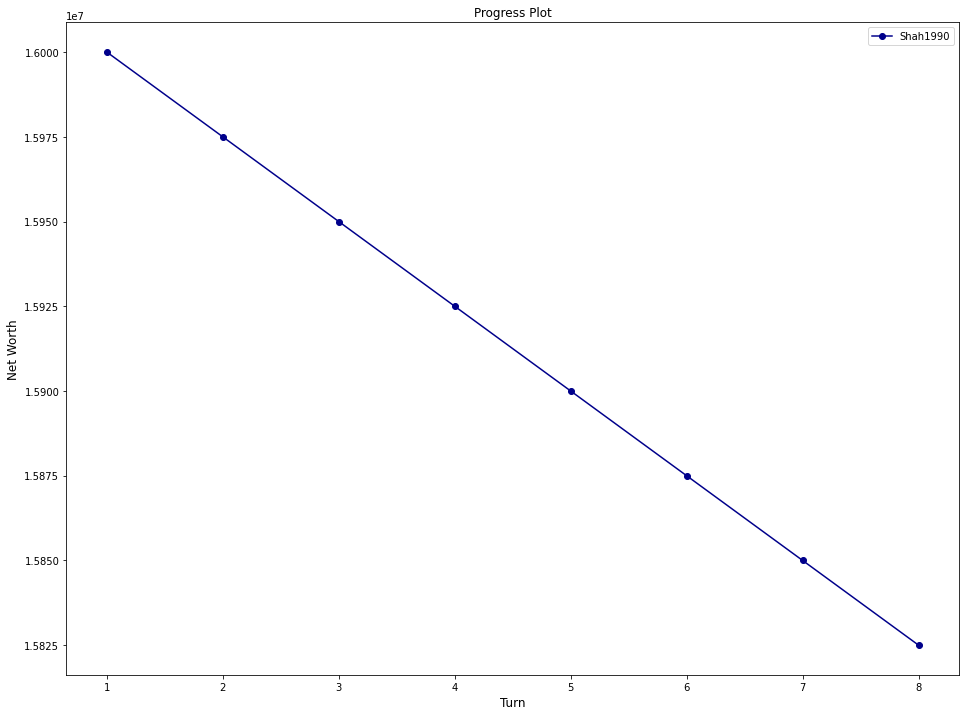

In [ ]:
Controller.fig

,machine_id,first_added_machine
land_id,,
31001,10001,NaN
31002,10002,NaN
31003,10003,NaN
31004,10004,NaN
31005,10005,NaN
32001,10001,NaN
32002,10002,NaN
32003,10003,NaN
32004,10004,NaN


In [ ]:
print(Land.available_lands)

[31001, 31002, 31003, 31004, 31005, 32001, 32002, 32003, 32004, 32005, 33001, 33002, 33003, 33004]


In [ ]:
print(type (Land.available_lands[0]))

<class 'int'>


In [ ]:
print(type (Land.available_lands))

<class 'list'>
